In [1]:
# THIS IS AMATEUR CODE
# USE AT YOUR OWN RISK


from multiprocessing import Pool
from tqdm.contrib.concurrent import process_map 
from functools import partial
import inspect
import numpy as np
import statistics
import time
import matplotlib.pyplot as plt

In [2]:
def parallel_task(func, iterable, Threads, *params):
    
    with open(f'./tmp_func.py', 'w') as file:
        file.write(inspect.getsource(func).replace(func.__name__, "task"))
        
    from tmp_func import task

    if __name__ == '__main__':
        func = partial(task, params)
        pool = Pool(processes=Threads)
        res = process_map(func, iterable, max_workers=Threads, chunksize=1)
        pool.close()
        return res
    else:
        raise "Not in Jupyter Notebook"

In [3]:
def RollTheD20sSaveAllRolls(params, id):
    import numpy as np

    SampleSize = params[0]

    rng = np.random.default_rng()

    rints = rng.integers(low=1, high=21, size=(SampleSize,3))
    
    Rolls = np.zeros((4, SampleSize))
    Nat1 = np.zeros(4)
    Nat20 = np.zeros(4)
    ExpandedCrit = np.zeros(4)



    for i in range(SampleSize):
        Rolls[0][i] = min(rints[i][0:2])
        Rolls[1][i] = rints[i][0]
        Rolls[2][i] = max(rints[i][0:2])
        Rolls[3][i] = max(rints[i][0:3])
        for j in range(4):
            if Rolls[j][i] == 1:
                Nat1[j] += 1
            if Rolls[j][i] == 20:
                Nat20[j] += 1
            if Rolls[j][i] > 18:
                ExpandedCrit[j] += 1
    
    return (Rolls, Nat1, Nat20, ExpandedCrit), id

In [4]:
def RollTheD20s(params, id):
    import numpy as np

    SampleSize = params[0]

    rng = np.random.default_rng()

    rints = rng.integers(low=1, high=21, size=(SampleSize,3))
    
    Rolls = np.zeros(4)
    Total = np.zeros(4)
    Nat1 = np.zeros(4)
    Nat20 = np.zeros(4)
    ExpandedCrit = np.zeros(4)
    Distribution = np.zeros((4,20))



    for i in range(SampleSize):
        Rolls[0] = min(rints[i][0:2])
        Rolls[1] = rints[i][0]
        Rolls[2] = max(rints[i][0:2])
        Rolls[3] = max(rints[i][0:3])
        Total[0] += Rolls[0]
        Total[1] += Rolls[1]
        Total[2] += Rolls[2]
        Total[3] += Rolls[3]
        for j in range(4):
            if Rolls[j] == 1:
                Nat1[j] += 1
            if Rolls[j] == 20:
                Nat20[j] += 1
            if Rolls[j] > 18:
                ExpandedCrit[j] += 1
        for k in range(20):
            for l in range(4):
                if Rolls[l] == k+1:
                    Distribution[l][k] += 1
    
    return (Total, Nat1, Nat20, ExpandedCrit, Distribution), SampleSize, id

In [5]:
NumberOfThreads = 4              # Number of Threads you want to Use!
TotalSamples = 10**6              # Total Rolls of 3 x D20s
SubSamples = 2*10**3              # Increase for more accurate progress bar. Has to be lower than TotalSamples


SamplesPerTask= int(np.floor(TotalSamples/SubSamples))

TotalRaw = np.zeros(4)
Nat1Raw = np.zeros(4)
Nat20Raw = np.zeros(4)
ExpandedCritRaw = np.zeros(4)
DistributionRaw = np.zeros((4,20))
TotalSamplesTest = 0

data_list = range(SubSamples)

t0 = time.time()

if SubSamples < TotalSamples:

    for res in parallel_task(RollTheD20s, data_list, NumberOfThreads, SamplesPerTask):

        TotalRaw += res[0][0]
        Nat1Raw += res[0][1]
        Nat20Raw += res[0][2]
        ExpandedCritRaw += res[0][3]
        DistributionRaw += res[0][4]
        TotalSamplesTest += res[1]


    t1 = time.time()
    Seconds = (t1-t0)%60
    Minutes = np.floor((t1-t0)/60)

    IniTime = "Initialization Completed in %.i minutes and %.2f seconds!" %(Minutes, Seconds)
    IniTimeS = "Initialization Completed in %.2f seconds!" %(Seconds)
    if Minutes > 0:
        print(IniTime)
    else:
        print(IniTimeS)

    if (TotalSamplesTest == TotalSamples) and (np.sum(DistributionRaw) == 4*TotalSamples):
        print("As expected, there were %.2e Samples taken!" %(TotalSamplesTest))
    else:
        print("Error! There were %.2e Samples taken." %(TotalSamplesTest))
        if (np.sum(DistributionRaw) != 4*TotalSamples):
            print("Something is wrong with the Distribution.")

else:
    print("Error! More sub-samples (%.2e) than total samples (%.2e)!" %(SubSamples, TotalSamples))

  0%|          | 0/2000 [00:00<?, ?it/s]

Initialization Completed in 36 minutes and 13.39 seconds!
As expected, there were 1.00e+09 Samples taken!


This analysis has been performed with 1.00e+09 rolls of 3 D20s


A roll with Disadvantage has the following properties:

Average: 7.18
Median: 6.00
Nat1s: 9.749%
Nat20s: 0.250%
19s or 20s: 1.000%


A roll with no modifiers has the following properties:

Average: 10.50
Median: 10.00
Nat1s: 5.000%
Nat20s: 5.000%
19s or 20s: 9.999%


A roll with Advantage has the following properties:

Average: 13.83
Median: 15.00
Nat1s: 0.250%
Nat20s: 9.750%
19s or 20s: 19.000%


A roll with Elven Accuracy has the following properties:

Average: 15.49
Median: 16.00
Nat1s: 0.012%
Nat20s: 14.263%
19s or 20s: 27.102%


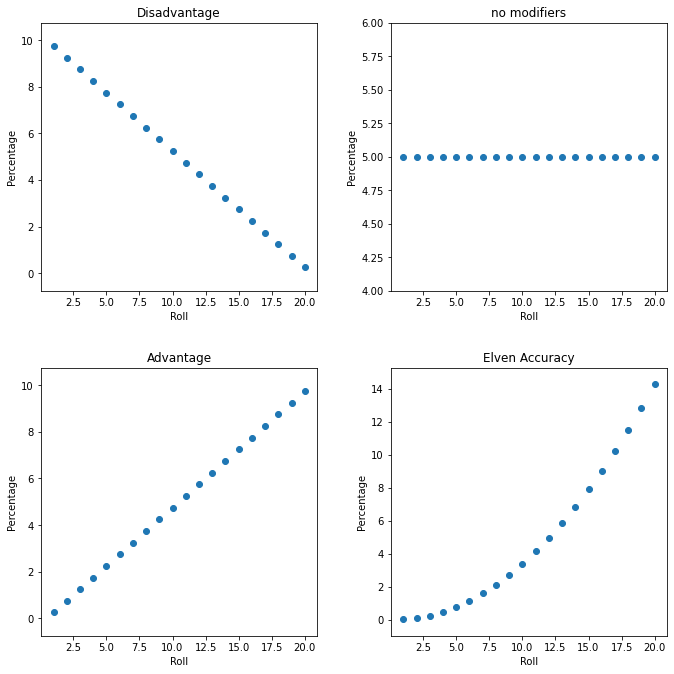

In [6]:
Names = ["Disadvantage", "no modifiers", "Advantage", "Elven Accuracy"]

AverageData = np.copy(TotalRaw)/TotalSamples
Nat1Data = np.copy(Nat1Raw)/TotalSamples
Nat20Data = np.copy(Nat20Raw)/TotalSamples
ExpandedCritData = np.copy(ExpandedCritRaw)/TotalSamples
DistributionData = np.copy(DistributionRaw)/TotalSamples
Median = np.zeros(4)

print("This analysis has been performed with %.2e rolls of 3 D20s" %(TotalSamples))    

plt.subplots(2,2, figsize=(10,10))
xx = np.linspace(1,20,20)

for i in range(4):
    Tester = 0
    j = 0
    while Tester < 0.5:
        Tester += DistributionData[i][j]
        if Tester >= 0.5:
            Median[i] = j+1
        j += 1
        
    
    plt.subplot(2,2,i+1)
    plt.scatter(xx, DistributionData[i][:]*100)
    plt.xlabel("Roll")
    plt.ylabel("Percentage")
    plt.title(Names[i])
    plt.ylim([min(DistributionData[i][:]*100)-1, max(DistributionData[i][:]*100)+1])
    
    print("\n\nA roll with %s has the following properties:\n" %(Names[i]))
    print("Average: %.2f" %(AverageData[i]))
    print("Median: %.2f" %(Median[i]))
    print("Nat1s: %.3f%%" %(Nat1Data[i]*100))
    print("Nat20s: %.3f%%" %(Nat20Data[i]*100))
    print("19s or 20s: %.3f%%" %(ExpandedCritData[i]*100))
    

plt.tight_layout(pad = 3.0)  
plt.show()